
# Gamma Regression


In [1]:
%matplotlib inline

We would like to use an example to show how the sparse-constrained optimization for gamma regression works in our program.

## Introduction to Gamma Regression
Gamma regression can be used when you have positive continuous response variables such as payments for insurance claims,
or the lifetime of a redundant system.
It is well known that the density of Gamma distribution can be represented as a function of
a mean parameter ($\mu$) and a shape parameter ($\alpha$), respectively,
$$
\begin{align}f(y \mid \mu, \alpha)=\frac{1}{y \Gamma(\alpha)}\left(\frac{\alpha y}{\mu}\right)^{\alpha} e^{-\alpha y / \mu} {I}_{(0, \infty)}(y),\end{align}
$$
where $I(\cdot)$ denotes the indicator function. In the Gamma regression model,
response variables are assumed to follow Gamma distributions. Specifically,

\begin{align}y_i \sim Gamma(\mu_i, \alpha),\end{align}


where $1/\mu_i = x_i^T\beta$.

With $n$ independent data of the explanatory variables $x$ and the response variable $y$, we can estimate $\beta$ by minimizing the negative log-likelihood function under sparsity constraint:

<a id='loss'></a>
$$
\arg \min _{\beta \in R^p} L(\beta):=-\frac{1}{n} \sum_{i=1}^n\left\{-\alpha \left( y_i x_i^T \beta - \log \left(x_i^T \beta\right)\right) + \alpha \log \alpha + \left(\alpha - 1\right) \log y - \log \Gamma \left(\alpha\right) \right\}, \text { s.t. }\|\beta\|_0 \leq s .\tag{1}
$$

Here is example python code for solving sparse gamma regression problem:


### Import necessary packages 

In [2]:
import numpy as np
import jax.numpy as jnp
from skscope import ScopeSolver, HTPSolver, GraspSolver
from skscope.numeric_solver import convex_solver_nlopt

### Set a seed

In [3]:
np.random.seed(123)

### Generate the data

Firstly, we define a data generator function to provide a way to generate suitable dataset for this task.

The model: 
* $y \sim \text{Gamma}(\mu, \alpha), \mu = 1/(x^T \beta + \epsilon), \beta \sim U[1, 2], \mu / \alpha\sim U[0.1, 100.1]$ in shape-scale definition.



In [4]:
def sample(p, k):
    full = np.arange(p)
    select = sorted(np.random.choice(full, k, replace=False))
    return select

def make_gamma_data(n, p, k, rho=0, corr_type="const", random_state=None):
    np.random.seed(random_state)
    if corr_type == "exp":
        # generate correlation matrix with exponential decay
        R = np.zeros((p, p))
        for i in range(p):
            for j in range(i, p):
                R[i, j] = rho ** abs(i - j)
        R = R + R.T - np.identity(p)
    elif corr_type == "const":
        # generate correlation matrix with constant correlation
        R = np.ones((p, p)) * rho
        for i in range(p):
            R[i, i] = 1
    else:
        raise ValueError(
            "corr_type should be \'const\' or \'exp\'")

    x = np.random.multivariate_normal(mean=np.zeros(p), cov=R, size=(n,))
    
    nonzero = sample(p, k)
    Tbeta = np.zeros(p)
    sign = np.random.choice([1, -1], k)

    Tbeta[nonzero] = np.random.uniform(1, 2, k) * sign
    # add noise
    eta = x @ Tbeta + np.random.normal(0, 1, n)
    # set coef_0 to make eta>0
    eta = eta + np.abs(np.min(eta)) + 1
    eta = 1 / eta
    # set the shape para of gamma uniformly in [0.1,100.1]
    shape_para = 100 * np.random.uniform(0, 1, 1) + 0.1
    
    y = np.random.gamma(
        shape=shape_para,
        scale=eta / shape_para,
        size=n)
    
    return x, y, Tbeta


We then use this function to generate a data set containg 500 observations and set only 5 of the 500 variables to have effect on the expectation of the response. 

In [5]:
n = 500
p = 500
s = 5
x, y, coef_ = make_gamma_data(n=n, p=p, k=s)

print("The predictor variables of the first five samples:",'\n',x[:,:5])
print("The first five noisy observations:", '\n', y[:5])

The predictor variables of the first five samples: 
 [[ 1.42438003 -1.67273534  1.68496893 -0.92153038 -0.87169826]
 [-0.4166771   0.07831742  1.60630648  0.78679904  0.33734078]
 [-0.63942892 -1.30434416 -2.37872185  0.28598812 -0.92929139]
 ...
 [-0.2602563   0.09467965 -0.27328825  0.24245864 -0.9253791 ]
 [-0.40261149 -0.44179093 -0.59412831 -0.03653229  3.27678225]
 [-0.81823476 -1.75733214  1.79670648  1.30459205  1.19748667]]
The first five noisy observations: 
 [0.10186504 0.07007082 0.07016093 0.10492319 0.06682085]


We augment data to avoid errors in the following codes:

In [6]:
X = np.hstack((np.ones((n, 1)), x))
true_params = np.hstack(([0.0], coef_))

### Define the loss function to calculate negative log-likelihood of Gamma regression

Secondly, we define the loss function `gamma_loss` accorting to [1](#loss) that matches the data generating function `make_gamma_data`.

In [7]:
def gamma_loss(params):
    xbeta = jnp.clip(X @ params, -30, 30)
    return jnp.mean(y * xbeta - jnp.log(xbeta)) 

We note that when computing the gamma loss, $x_i^T \beta$ may less than 0 and give `np.nan` or raise error, we should change the initial value of the parameters to make sure that $x_i^T \beta$ > 0, the following code give an example to deal with this problem.

In [8]:
def convex_solver_gamma(
    loss_fn,
    value_and_grad,
    params,
    optim_variable_set,
    data,
):
    """
    change the initial value of the parameters to let X @ params > 0
    """
    m = np.min(X @ params)
    if m <= 0.0:
        params[0] -= m
    return convex_solver_nlopt(loss_fn, value_and_grad, params, optim_variable_set, data)


### Use scope to solve the sparse gamma regression problem

After defining the data generation and loss function, we can call `ScopeSolver` to solve the sparse-constrained optimization problem.

In [9]:
solver = ScopeSolver(p+1, s+1, preselect=[0], numeric_solver=convex_solver_gamma)
params = solver.solve(gamma_loss, init_params=np.hstack(([1.0], np.zeros(p))), jit=True)

Now the `solver.params` contains the coefficients of gamma model with no more than 5 variables. That is, those variables with a coefficient 0 is unused in the model:

In [10]:
print(solver.params)

[10.96270773  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         

We can further compare the coefficients estimated by `scope` and the real coefficients in two-fold:

* The true support set and the estimated support set

* The true nonzero parameters and the estimated nonzero parameters


In [11]:
true_support_set =  np.nonzero(true_params)[0]
estimated_support_set =  (solver.support_set)[1:]

print("True support set: ", true_support_set)
print("Estimated support set: ", estimated_support_set)

True support set:  [ 94 151 172 374 408]
Estimated support set:  [ 94 151 172 374 408]


In [12]:
print("True parameters: ", true_params[true_support_set])
print("Estimated parameters: ", solver.params[estimated_support_set])

True parameters:  [1.16044681 1.06065828 1.78922069 1.20619509 1.55663571]
Estimated parameters:  [1.2021258  0.99600871 1.74258709 1.18841825 1.46535362]


We can find that the support set solved by scope completely coincides with the support set of the simulation data.

### More on the results

We can plot the sparse signal recovering from the noisy observations to visualize the results.

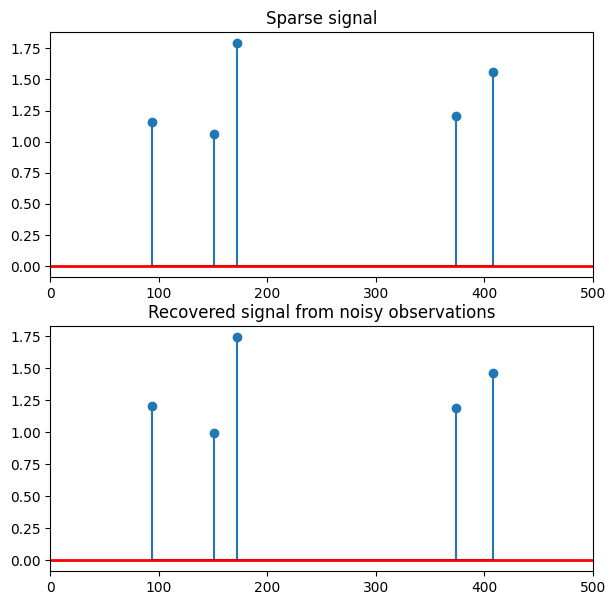

In [13]:
import matplotlib.pyplot as plt

# plot the sparse signal
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.stem(true_support_set, true_params[true_support_set], markerfmt='o', basefmt='k-')
plt.plot([0, 500], [0, 0], 'r-', lw=2)
plt.xlim(0, 500)
plt.title("Sparse signal")

# plot the noisy reconstruction
plt.subplot(2, 1, 2)
plt.stem(estimated_support_set, solver.params[estimated_support_set], markerfmt='o', basefmt='k-')
plt.plot([0, 500], [0, 0], 'r-', lw=2)
plt.xlim(0, 500)
plt.title("Recovered signal from noisy observations")

plt.show()

### References

<div id="refer-1"></div>

- [1] Wikipedia, "Gamma distribution".
https://en.wikipedia.org/wiki/Gamma_distribution

<div id="refer-2"></div>

- [2] Abess docs, "make_glm_data".
https://abess.readthedocs.io/en/latest/Python-package/datasets/glm.html
